<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/timeseries/ml/gradient_boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#### Download dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("abhisheksjha/time-series-air-quality-data-of-india-2010-2023")
print("Path to dataset files:", path)

100%|██████████| 464M/464M [00:08<00:00, 58.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023/versions/2


In [3]:
path += "/AP001.csv"

In [4]:
aq_dataset = pd.read_csv(path, parse_dates=["From Date", "To Date"], index_col='From Date')

In [5]:
aq_dataset.head()

,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
From Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,2016-07-01 11:00:00,10.67,39.0,17.67,39.2,32.33,7.07,6.60,0.48,14.5,...,33.43,71.67,2.30,226.33,123.67,NaN,-0.1,0.1,0.0,23.05
2016-07-01 11:00:00,2016-07-01 12:00:00,2.00,39.0,20.50,41.9,35.80,7.40,NaN,0.49,15.0,...,33.70,70.00,2.50,223.00,186.00,NaN,-0.1,0.1,0.0,NaN
2016-07-01 12:00:00,2016-07-01 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 13:00:00,2016-07-01 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 14:00:00,2016-07-01 15:00:00,20.50,50.0,15.40,43.6,32.78,6.35,6.38,0.47,10.5,...,33.57,63.50,1.88,223.00,240.50,NaN,-0.1,0.1,0.0,NaN


In [6]:
aq_dataset.columns

Index(['To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
       'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)',
       'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)'],
      dtype='object')

<Axes: xlabel='From Date'>

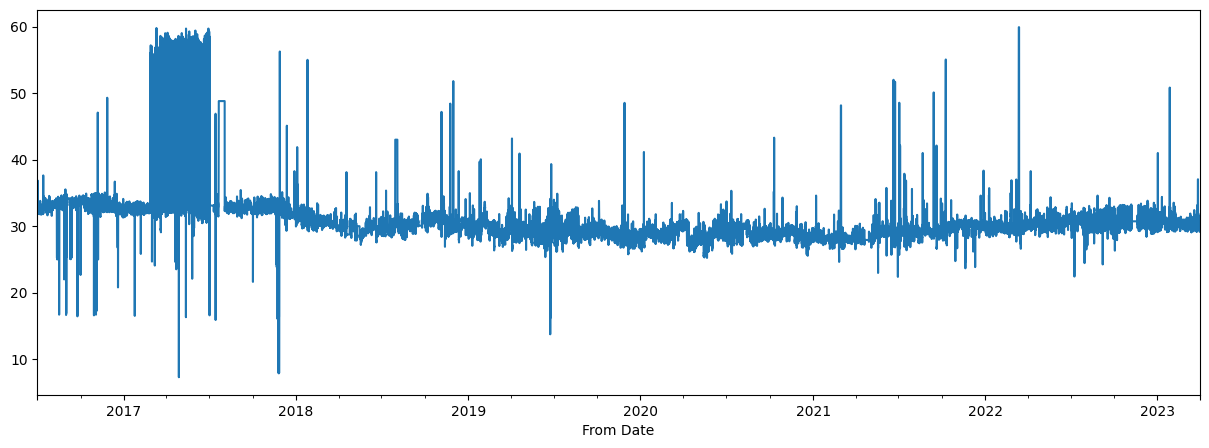

In [7]:
aq_dataset['Temp (degree C)'].ffill().plot(figsize=(15, 5))

##### Prepare features

In [8]:
ts = aq_dataset['Temp (degree C)'].ffill()
df = pd.DataFrame(ts)

for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df['Temp (degree C)'].shift(lag)

df['roll7_mean'] = df['Temp (degree C)'].rolling(7).mean().shift(1)
df['roll7_std'] = df['Temp (degree C)'].rolling(7).std().shift(1)

df = df.dropna()


In [9]:
split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

X_train = train.drop(columns=['Temp (degree C)'])
y_train = train['Temp (degree C)']
X_test = test.drop(columns=['Temp (degree C)'])
y_test = test['Temp (degree C)']


In [14]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


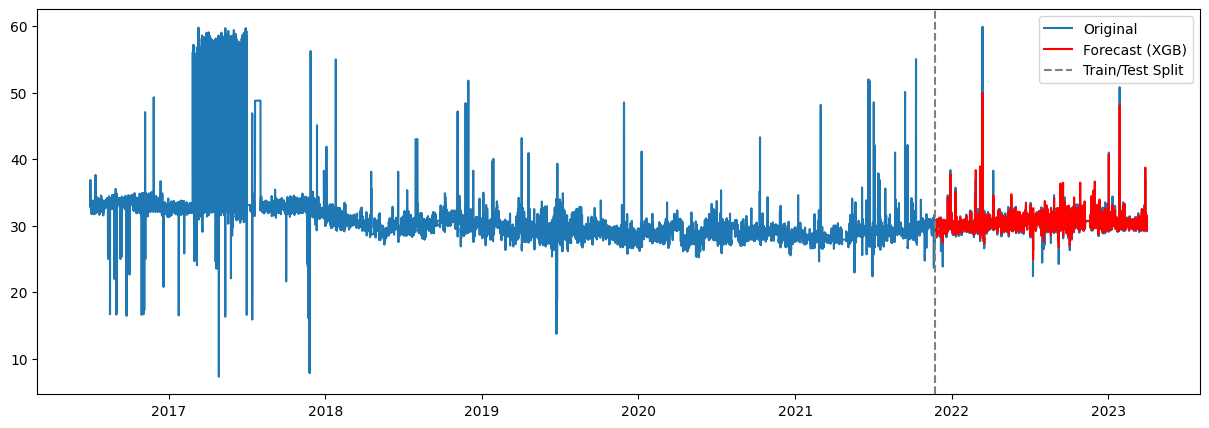

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts.values, label='Original')
plt.plot(test.index, y_pred, label='Forecast (XGB)', color='red')
plt.axvline(ts.index[split_idx], color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()


In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'R²'],
    'Value': [mae, mse, rmse, mape, r2]
})
print(metrics_df)


     Metric     Value
0       MAE  0.318164
1       MSE  1.081641
2      RMSE  1.040020
3  MAPE (%)  0.981420
4        R²  0.573058
